In [1]:
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
from utils.resizer import Resizer

import matplotlib.pyplot as plt
from tqdm import tqdm

## Load Stable Diffusion

In [2]:
from ldm.util import instantiate_from_config
from omegaconf import OmegaConf

def load_model_from_config(config, ckpt, device):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.to(device)
    model.eval()
    return model

In [ ]:
device = torch.device("cuda:0")
torch.cuda.set_device(0) # For multiple GPUs

config_path = "configs/stable-diffusion/v1-inference.yaml"
model_path = ""

config = OmegaConf.load(config_path)
model = load_model_from_config(config, model_path, device)

## Load style image

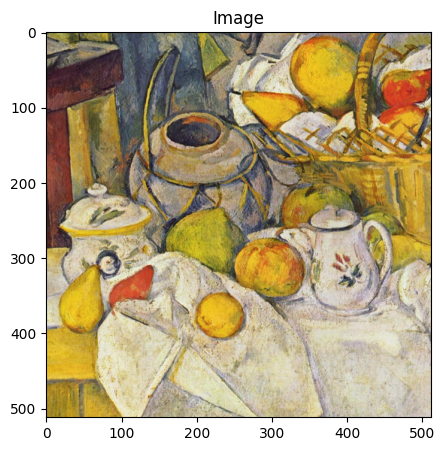

In [14]:
img_path = "../assets/cezanne.jpg"

img = np.asarray(Image.open(img_path).crop((300,300,1300,1300)).resize((512,512)))[:,:,:3]
img = torch.from_numpy(img.copy())
img = (img.permute([2,0,1]) / 125.7 - 1).unsqueeze(0).to(device)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax.set_title("Image")
plt.show()

## Load CLIP

In [ ]:
# Load CLIP
import clip
import torchvision

clip_model, clip_preprocess = clip.load("ViT-B/16", device=device)
clip_model.eval()
clip_preprocess = torchvision.transforms.Compose([
    Resizer((1,3,512,512), output_shape=(1,3,224,224)).to(device),
    torchvision.transforms.Normalize(mean=(0.48145466*2-1, 0.4578275*2-1, 0.40821073*2-1), std=(0.26862954*2, 0.26130258*2, 0.27577711*2)), # This expects [-1,1] images as input
])

In [16]:
# Set CLIP layer to use for style
clip_features = {}
def get_features(name):
    def hook(model, input, output):
        clip_features[name] = output
    return hook

clip_model.visual.transformer.resblocks[2].register_forward_hook(get_features("style_features"))

## Inference

In [17]:
# Extract reference CLIP features
with torch.no_grad():
    clip_model.encode_image(clip_preprocess(img.to(device)))
    ref_image_features = clip_features['style_features'].clone()
    ref_image_features = ref_image_features[1:, 0, :]
    gram_ref = torch.mm(ref_image_features.t(), ref_image_features)

In [20]:
# Model forward pass
def model_pred(model, x, t, cond, uncond=None, w=1.0):
    with torch.no_grad():
        with model.ema_scope():
            t_cond = torch.tensor(x.shape[0]*[t]).view(-1).float().to(device)

            if w > 1.0:
                # Classifer-free guidance
                epsilon_cond_uncond = model.model.diffusion_model(
                    torch.cat((x,x), dim=0), 
                    torch.cat((t_cond,t_cond), dim=0),
                    context=torch.cat((cond, uncond), dim=0))
                bs = epsilon_cond_uncond.shape[0]//2
                epsilon_cond, epsilon_uncond = epsilon_cond_uncond[:bs,...], epsilon_cond_uncond[bs:,...]
                epsilon = (1+w)*epsilon_cond - w*epsilon_uncond

            else:
                epsilon = model.model.diffusion_model(x, t_cond, context=cond)
    return epsilon


# Diffusion parameters
t = 1000
xt = torch.randn((1,4,64,64), device=device)
stride = 50
timesteps = range(t, 0, -stride)

# Inference parameters
n_steps = 5
lr = np.linspace(0.5, 0.1, n_steps)
h = 0.005
cfg_guidance = 2.0

# Text caption
caption = 'a photo of a cat'
with torch.no_grad():
    cond = model.get_learned_conditioning(caption).tile(1,1,1)
    uncond = model.get_learned_conditioning('')


# Run inference
for idx, t in tqdm(enumerate(timesteps)):
    atbar = model.alphas_cumprod[t-1].view(1,1,1,1)
    atbar_prev = model.alphas_cumprod[max(t-1-stride,1)].view(1,1,1,1)
    beta_tilde = (model.betas[t-1] * (1 - atbar_prev) / (1 - atbar)).view(1,1,1,1)

    # Compute x_0(x_t, t)
    epsilon = model_pred(model, xt, t, cond, uncond, w=cfg_guidance)
    x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)

    for k in range(n_steps):
        # Comptue e
        xgrad = torch.zeros((1,4,64,64), device=device, requires_grad=True)
        with torch.no_grad():
            xgrad.data = x0_pred.clone()
            xgrad.grad = None
        img_pred = model.differentiable_decode_first_stage(xgrad)

        # Style gradient #
        # Computed as the norm || Gram(CLIP(reference)) - Gram(CLIP(x0_pred)) ||
        img_pred = clip_preprocess(img_pred)
        clip_model.encode_image(img_pred)
        pred_image_features = clip_features['style_features'].clone()
        pred_image_features = pred_image_features[1:, 0, :]

        gram_x0 = torch.mm(pred_image_features.t(), pred_image_features)
        error = torch.linalg.norm(gram_ref - gram_x0)

        error_dir = -torch.autograd.grad(error, xgrad)[0]
        error_dir = error_dir / error_dir.abs().max()

        # Compute x_0(x_t + h*e, t)
        h_adaptive = h / error_dir.abs().max()
        xt_error_dir = xt + h_adaptive*error_dir
        epsilon_error_dir = model_pred(model, xt_error_dir, t, cond, uncond, w=cfg_guidance)
        x0_pred_error_dir = xt_error_dir / torch.sqrt(atbar) - epsilon_error_dir * torch.sqrt((1-atbar)/atbar)

        # Compute finite differences
        grad = (x0_pred_error_dir - x0_pred)
        grad = grad / grad.abs().max()

        # Apply update
        xt = xt + lr[k]*grad

        # Recompute x_0(x_t, t)
        epsilon = model_pred(model, xt, t, cond, uncond, w=cfg_guidance)
        x0_pred = xt / torch.sqrt(atbar) - epsilon * torch.sqrt((1-atbar)/atbar)


    # DDIM step
    xt = torch.sqrt(atbar_prev)*x0_pred + torch.sqrt(1-atbar_prev-beta_tilde)*epsilon + torch.sqrt(beta_tilde)*torch.randn_like(xt)


0it [00:00, ?it/s]

20it [00:55,  2.76s/it]


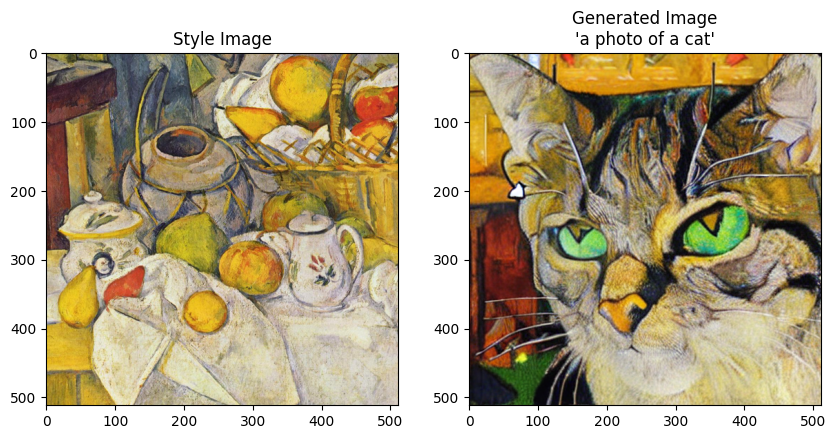

In [21]:
# Visualize result
with torch.no_grad():
    pred_img = model.decode_first_stage(x0_pred)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow((0.5*(img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[0].set_title("Style Image")
ax[1].imshow((0.5*(pred_img+1)).clip(0,1)[0].cpu().numpy().transpose([1,2,0]))
ax[1].set_title(f"Generated Image\n'{caption}'")
plt.show()